# NOTEBOOK P7 FFT LEARNABLE


In [126]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from PIL import Image, ImageOps
from PIL import Image as pil
from p7_utilities import custom_p7_melspectrogram
from p7_utilities import custom_p7_spectrograms_for_audio
from pkg_resources import parse_version

from STFT.stft import STFT

if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS
    
import matplotlib.cm as cm
dataset_root_folder='/home/christophe/birdclef/'
audio_input_folder = dataset_root_folder+"train_audio"
image_output_folder = dataset_root_folder+"train_images"
meta_data = pd.read_csv(dataset_root_folder+"eBird_Taxonomy_v2021.csv")
birds_of_interest = [
    "Eurasian Coot", #
    "Blyth's Reed Warbler", #
    "Gray Heron", #
    "Greenish Warbler", #
    "Black-crowned Night-Heron", 
    "Rose-ringed Parakeet", #
    "Greater Racket-tailed Drongo", #
    "White-breasted Waterhen", #
    "Gray-headed Canary-Flycatcher", #
    "Great Egret", #
    "Little Egret", #
    "Red-whiskered Bulbul"#
]

print(len(birds_of_interest))
metadata_of_interest = meta_data[meta_data['PRIMARY_COM_NAME'].isin(birds_of_interest)]
print(metadata_of_interest.shape)
metadata_of_interest


12
(12, 9)


,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
2753,5346,species,eurcoo,Eurasian Coot,Fulica atra,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
2797,5407,species,whbwat1,White-breasted Waterhen,Amaurornis phoenicurus,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
4013,7176,species,graher1,Gray Heron,Ardea cinerea,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4030,7200,species,greegr,Great Egret,Ardea alba,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4045,7217,species,litegr,Little Egret,Egretta garzetta,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4095,7305,species,bcnher,Black-crowned Night-Heron,Nycticorax nycticorax,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
6335,11807,species,rorpar,Rose-ringed Parakeet,Psittacula krameri,Psittaciformes,Psittaculidae (Old World Parrots),NaN,NaN
10079,19754,species,grtdro1,Greater Racket-tailed Drongo,Dicrurus paradiseus,Passeriformes,Dicruridae (Drongos),NaN,NaN
10670,21121,species,gyhcaf1,Gray-headed Canary-Flycatcher,Culicicapa ceylonensis,Passeriformes,Stenostiridae (Fairy Flycatchers),NaN,NaN
11263,22828,species,blrwar1,Blyth's Reed Warbler,Acrocephalus dumetorum,Passeriformes,Acrocephalidae (Reed Warblers and Allies),NaN,NaN


# Settings

In [127]:
#generates spectrograms are generated on audio clips this long
#audio clips shorter than this are ignored
audio_duration = 5.0

#generates up to this many clips per file (multiples of audio_duration)
#remainders of audio clip length / audio_duration are ignored
max_clips_per_audio_file = 1000

#image size (image_size x image_size)
image_size = 224

#processes up to this many audio files per species
max_audio_input_per_species = 1000

#setting this above 0 will cause processing to start at a folder after the first
#useful for restarting / continuing in case of running out of time / crash (folders are processed alphabetically)
start_at_folder_offset = 0

# Function to lookup bird species

In [128]:


def bird_species_from_folder(path):
    if path.endswith('/'):
        path = path[:-1]

    last_folder = os.path.basename(path)
    primary_com_name = metadata_of_interest.loc[metadata_of_interest['SPECIES_CODE'] == last_folder, 'PRIMARY_COM_NAME']
    primary_com_name_str = primary_com_name.iloc[0] if not primary_com_name.empty else ''    
    return f"{primary_com_name_str} ({last_folder})"

In [129]:
def spectrograms_for_audio(dirname, filename, preview=False):
    # Calculate total duration of the audio file
    audio_path = os.path.join(dirname, filename)
    audio_data, sr = librosa.load(audio_path, sr=None)
    total_duration = librosa.get_duration(path=audio_path)
    
    # Determine how many full segments of audio_duration fit in the audio file
    num_segments = int(total_duration // audio_duration)
    #print('debug number f segments: ',num_segments)
    if num_segments == 0: return 0
    if num_segments > max_clips_per_audio_file: num_segments = max_clips_per_audio_file
        
    for segment in range(num_segments):

        offset_samples = int(segment * audio_duration * sr)
        end_samples = int(offset_samples + audio_duration * sr)
        
        segment_data = audio_data[offset_samples:end_samples]
        
        S = librosa.feature.melspectrogram(y=segment_data, sr=sr, n_mels=128)
        S_db = librosa.amplitude_to_db(S, ref=np.max)
                
        #convert spectrogram data into directly into image (much faster than matplotlib)
        normalized_array = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
        
        #set color mapping 
        spectrogram_image = cm.magma(normalized_array)[:, :, :3]
        spectrogram_image = (spectrogram_image * 255).astype(np.uint8)
        spectrogram_image = Image.fromarray(spectrogram_image)
        
        #resize and flip (so consistent with original dataset)
        spectrogram_image = spectrogram_image.resize((image_size, image_size), Image.ANTIALIAS)
        spectrogram_image = ImageOps.flip(spectrogram_image)
        
        if preview:
            display(Audio(data=segment_data, rate=sr))
            return spectrogram_image
        
        output_folder = os.path.join(image_output_folder, os.path.basename(os.path.normpath(dirname)))
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Naming files with an offset to indicate seconds offset
        base_filename = filename.replace('.ogg', '')
        output_filename = os.path.join(output_folder, f"{base_filename}_{int((segment + 1) * audio_duration):02d}.png")
        
        spectrogram_image.save(output_filename)

    return num_segments

# A few demos


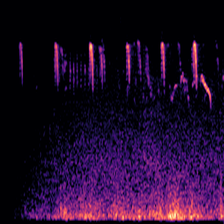

In [5]:
spectrograms_for_audio(f"{audio_input_folder}/zitcis1/", "XC655341.ogg", preview=True)
# print(num_segements)

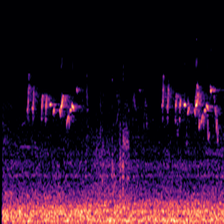

In [18]:

spectrograms_for_audio(f"{audio_input_folder}/bkcbul1/", "XC129030.ogg", preview=True)

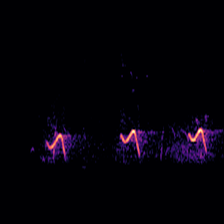

In [19]:
spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg", preview=True)

# Generate the spectrograms!
### 'X' is displayed for any file not processed due to being shorter than audio_duration

In [6]:
species_codes_of_interest = metadata_of_interest['SPECIES_CODE'].tolist()
species_codes_of_interest

['eurcoo',
 'whbwat1',
 'graher1',
 'greegr',
 'litegr',
 'bcnher',
 'rorpar',
 'grtdro1',
 'gyhcaf1',
 'blrwar1',
 'rewbul',
 'grewar3']

In [21]:
# from PIL import Image as pil
# from pkg_resources import parse_version

# if parse_version(pil.__version__)>=parse_version('10.0.0'):
#     Image.ANTIALIAS=Image.LANCZOS

# List everything in the audio input folder
entries = os.listdir(audio_input_folder)

# Filter to get only directories
# subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry))]
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry)) and entry in species_codes_of_interest]

# Sort the directories
subdirectories.sort()

#to start processing at a certain folder offset
subdirectories = subdirectories[start_at_folder_offset:]

folder_count = len(subdirectories)
folders_processed = 0

# Iterate through each sorted directory
total_images = 0
print('27 june first test images will be generated only for 1 folder')

for subdir in subdirectories:
    print('for now no image created')
    break
    subdir_path = os.path.join(audio_input_folder, subdir)
    folders_processed += 1
    print("\n", bird_species_from_folder(subdir_path), folders_processed, "/", folder_count)

    # List files in the current directory (in any order)
    filenames = os.listdir(subdir_path)
    
    # Process up to max_audio_input_per_species files
    images_this_species = 0
    for filename in filenames[:max_audio_input_per_species]:
        images_generated = spectrograms_for_audio(subdir_path, filename,preview=False)
        if images_generated > 0:
            images_this_species += images_generated
            print(".", end = "")
        else:
            print("X", end = "")
    print (f"({images_this_species} images generated)")
    total_images += images_this_species
    if folders_processed>0:
        break
print ("\n", total_images, "total images generated")
                

27 june first test images will be generated only for 1 folder
for now no image created

 0 total images generated


# P7 first explorations 
Ici nous faisons des tests avec la stft (github nvidia)

stft ok
spectrogram ok

TODO make it trainable!!!

1.8750406e-17


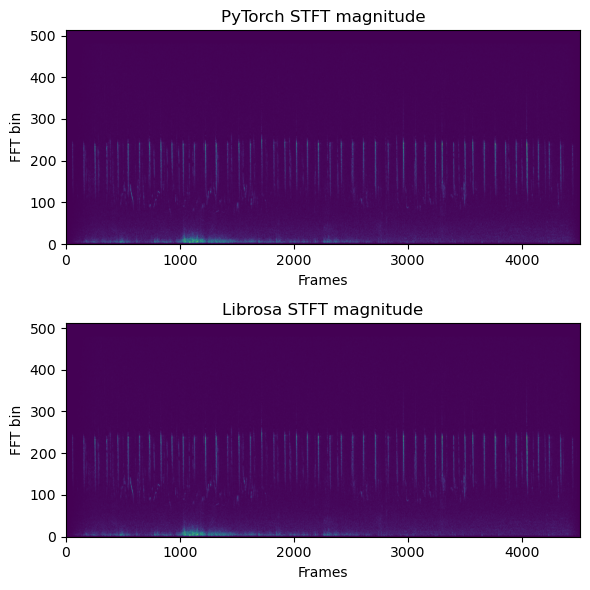

In [131]:
import torch
import numpy as np
import librosa 
import matplotlib.pyplot as plt

audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)

audio,_ = librosa.load(audio_file_test,sr=None)

audio_for_spectro=audio.copy()
device = 'cpu'
filter_length = 1024
hop_length = 256
win_length = 1024 # doesn't need to be specified. if not specified, it's the same as filter_length
window = 'hann'
librosa_stft = librosa.stft(audio, n_fft=filter_length, hop_length=hop_length, window=window)
_magnitude = np.abs(librosa_stft)

audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
audio = audio.to(device)

stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
).to(device)

magnitude, phase = stft.transform(audio)
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.title('PyTorch STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+magnitude[0].cpu().data.numpy()), aspect='auto', origin='lower')

plt.subplot(212)
plt.title('Librosa STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+_magnitude), aspect='auto', origin='lower')
plt.tight_layout()
plt.savefig('/home/christophe/birdclef/images_stft/stft.png')

output = stft.inverse(magnitude, phase)
output = output.cpu().data.numpy()[..., :]
audio = audio.cpu().data.numpy()[..., :]
print(np.mean((output - audio) ** 2)) # on order of 1e-17

# NVIDIA TACHOTRON
Ici nous récupérons une classe tachotron fournie par NVIDIA héritant de nn.Module.
Initialement cette classe n'était pas entrainable, nous l'avons donc modifiée.
Dans notre version, mel_basis est modifaible durant l'entrainement et nous avons rajouté une méthode forward qui renvoie un spectrogramme

In [133]:
from librosa.filters import mel as librosa_mel_fn
import torch
import torch.nn as nn

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C

class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        mel_basis = librosa_mel_fn(
            sr=sampling_rate, n_fft=filter_length,n_mels= n_mel_channels,fmin= mel_fmin,fmax= mel_fmax)
        
        

        self.mel_basis = nn.Parameter(torch.from_numpy(mel_basis).float())
        # COMMENTED TO MAKE IT LEARNABLE
        #mel_basis = torch.from_numpy(mel_basis).float()
        #self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """

        ##### COMMENTED!!!!!########
        # assert(torch.min(y.data) >= -1)
        # assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output
    
    def forward(self,y):
        return self.mel_spectrogram(y)


##### TESTS ######
tacotron_stft=TacotronSTFT()
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"
assert os.path.exists(audio_file_test)


FS=32000

FIXED_LENGTH = int(5.0 * FS)  # 5 seconds
def get_audio_data(audio_raw_file):
    audio_data, _ = librosa.load(audio_raw_file, sr=FS)
    if len(audio_data) < FIXED_LENGTH:
        
        # Pad with zeros
        pad_width = FIXED_LENGTH - len(audio_data)
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant')
    else:
        
        # Truncate
        audio_data = audio_data[:FIXED_LENGTH]

    return torch.from_numpy(audio_data).unsqueeze(0)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)

spectro = tacotron_stft.mel_spectrogram(y=audio_torch_spectro)

output_tacrotron = tacotron_stft(y=audio_torch_spectro.unsqueeze(0))
print('Output of tachrotron layer:')
assert type(output_tacrotron) is torch.Tensor
print(type(output_tacrotron))
assert output_tacrotron.shape==(1,80,626), f'{output_tacrotron.shape}'
print(output_tacrotron.shape)

assert np.allclose(output_tacrotron.detach().numpy(), spectro.detach().numpy())

Output of tachrotron layer:
<class 'torch.Tensor'>
torch.Size([1, 80, 626])


# Data is normalized !!

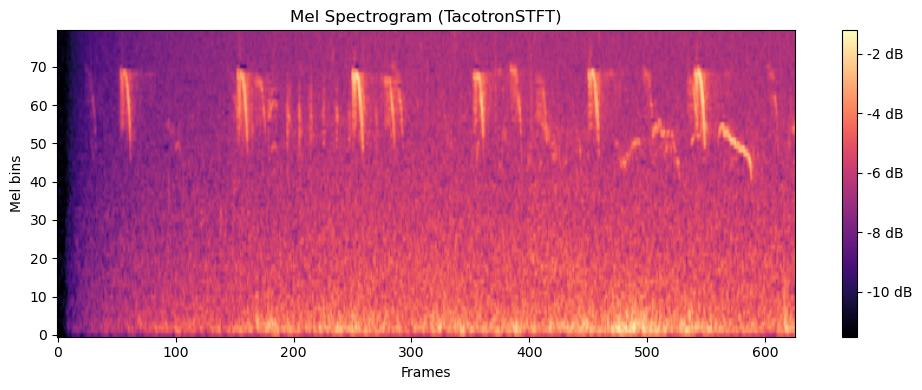

In [134]:
plt.figure(figsize=(10, 4))
plt.imshow(spectro.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [140]:

import torch

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load EfficientNet with pretrained weights
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Replace first conv to accept 1-channel input
        old_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None,
        )
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        self.model.features[0][0] = new_conv

        # Replace classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
    # TODO see with debugger
    def forward(self, x):
       
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)  
        elif x.dim() == 3:
            x = x.unsqueeze(1) 

        return self.model(x)
    
model = CustomEfficientNet(num_classes=182)

output = model(spectro)  # shape: [1, 10]

output3=model(output_tacrotron)

print(output.shape)


torch.Size([1, 182])


# BiirdNetFFT
Ici nous accolons notre classe Tachrotron et un réseau EfficientNet 

In [142]:
import torch
import torch.nn as nn

class BirdNetFFT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.spectro_layer=TacotronSTFT()

        self.model = CustomEfficientNet(num_classes=num_classes)

    def forward(self, x):
        
        x=self.spectro_layer(x)
        
        return self.model(x)
    
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"

audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"

assert os.path.exists(audio_file_test)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)


bird_model = BirdNetFFT(num_classes=182)

output_bird=bird_model(audio_torch_spectro)


print(torch.argmax(output_bird))


tensor(153)


# test of gradient

Ici nous vérifions que la couche mel_basis est bien entraînable

In [143]:
model_b = BirdNetFFT(num_classes=182)
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)


audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)
print(audio_torch_spectro.shape)

y = model_b(audio_torch_spectro)  # forward

loss = y.sum()
loss.backward()

assert model_b.spectro_layer.mel_basis.grad is not None,'layer mel_basis not trainable'


torch.Size([1, 160000])


# dataset building

Le dataset renvoie le spectrogramm et le label (l'index de l'espece d'oiseau) associé

In [144]:

root_folder='/home/christophe/birdclef'
folder_store_audio=root_folder+audio_input_folder
label_list = sorted(os.listdir(os.path.join(root_folder, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
test_audio_processed=get_audio_data(audio_raw_file=audio_file_test)
print(test_audio_processed.shape)
def get_id_from_label(dict_label:dict,label:str):
    return dict_label[label]
id_test=get_id_from_label(label2id,'asikoe2')
assert id_test==4
print(id_test)

torch.Size([1, 160000])
4


In [ ]:
id2label

In [ ]:
import os
import torch
from torch.utils.data import Dataset, Subset,DataLoader
from torch.utils.data import random_split

class BirdAudioDataset(Dataset):
    def __init__(self, root_dir, audio_extensions=(".ogg",)):
        self.root_dir = root_dir
        self.audio_extensions = audio_extensions
        self.samples = []

        # Walk through each subdirectory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith(audio_extensions):
                    fpath = os.path.join(label_path, fname)
                    self.samples.append((fpath, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]

        input_model=get_audio_data(audio_path)
        
        id_label=get_id_from_label(dict_label=label2id,label=label)
        return input_model, id_label
    


# Load entire dataset
dataset = BirdAudioDataset("/home/christophe/birdclef/train_audio")

total_size = len(dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size  = total_size - train_size - valid_size  # ensures full coverage


generator = torch.Generator().manual_seed(42)
train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size], generator=generator)


train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=8)

# Inspect first few samples
for i in range(20):
    data,label=dataset[i]
    print(label)
    output_bird_test=bird_model(data)
    

56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56


# Entrainement du modèle

In [146]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_b = BirdNetFFT(num_classes=182)
tacho_test=TacotronSTFT()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model_b.train() 
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model_b(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_train_loss += loss.item() * inputs.size(0) # Accumulate batch loss
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%")

    # Validation Phase
    model_b.eval()  # Set model to evaluation mode
    running_valid_loss = 0.0
    correct_valid_predictions = 0
    total_valid_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_b(inputs)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_valid_samples += labels.size(0)
            correct_valid_predictions += (predicted == labels).sum().item()

    epoch_valid_loss = running_valid_loss / total_valid_samples
    epoch_valid_accuracy = 100 * correct_valid_predictions / total_valid_samples
    print(f"Epoch {epoch+1}/{num_epochs} - Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.2f}%")

print("Training complete!")

# Optional: Evaluate on the test set after training
print("\nEvaluating on Test Set...")
model_b.eval()
correct_test_predictions = 0
total_test_samples = 0
running_test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_b(inputs)
        loss = criterion(outputs, labels)

        running_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_samples += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

test_loss = running_test_loss / total_test_samples
test_accuracy = 100 * correct_test_predictions / total_test_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    


cpu


KeyboardInterrupt: 

In [147]:
import torch
print(torch.cuda.is_available())        # Should be True
print(torch.version.cuda)               # Should show the CUDA version PyTorch was built with
print(torch.backends.cudnn.version())   # CUDNN version
print(torch.cuda.device_count())        # Number of visible CUDA devices

False
None
None
0


# check spectrogramm

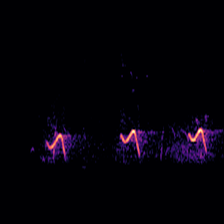

In [6]:

custom_p7_spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg",image_output_folder='dummy', preview=True)

In [ ]:
# from typing import Any, Optional, Union, Collection
# from typing_extensions import Literal
# from typing import Callable, Generator, List, TypeVar, Union, Tuple, Any, Sequence
# from numpy.typing import ArrayLike
# from numpy.typing import DTypeLike
# from librosa._cache import cache
# import numpy as np
# import librosa.util
# import scipy
# import warnings

# _WindowSpec = Union[str, Tuple[Any, ...], float, Callable[[int], np.ndarray], ArrayLike]

# @cache(level=10)
# def get_window(
#     window: _WindowSpec,
#     Nx: int,
#     *,
#     fftbins: Optional[bool] = True,
# ) -> np.ndarray:
#     """Compute a window function.

#     This is a wrapper for `scipy.signal.get_window` that additionally
#     supports callable or pre-computed windows.

#     Parameters
#     ----------
#     window : string, tuple, number, callable, or list-like
#         The window specification:

#         - If string, it's the name of the window function (e.g., `'hann'`)
#         - If tuple, it's the name of the window function and any parameters
#           (e.g., `('kaiser', 4.0)`)
#         - If numeric, it is treated as the beta parameter of the `'kaiser'`
#           window, as in `scipy.signal.get_window`.
#         - If callable, it's a function that accepts one integer argument
#           (the window length)
#         - If list-like, it's a pre-computed window of the correct length `Nx`

#     Nx : int > 0
#         The length of the window

#     fftbins : bool, optional
#         If True (default), create a periodic window for use with FFT
#         If False, create a symmetric window for filter design applications.

#     Returns
#     -------
#     get_window : np.ndarray
#         A window of length `Nx` and type `window`

#     See Also
#     --------
#     scipy.signal.get_window

#     Notes
#     -----
#     This function caches at level 10.

#     Raises
#     ------
#     ParameterError
#         If `window` is supplied as a vector of length != `n_fft`,
#         or is otherwise mis-specified.
#     """
#     if callable(window):
#         return window(Nx)

#     elif isinstance(window, (str, tuple)) or np.isscalar(window):
#         # TODO: if we add custom window functions in librosa, call them here

#         win: np.ndarray = scipy.signal.get_window(window, Nx, fftbins=fftbins)
#         return win

#     elif isinstance(window, (np.ndarray, list)):
#         if len(window) == Nx:
#             return np.asarray(window)

#         raise ValueError(f"Window size mismatch: {len(window):d} != {Nx:d}")
#     else:
#         raise ValueError(f"Invalid window specification: {window!r}")


# _STFTPad = Literal[
#     "constant",
#     "edge",
#     "linear_ramp",
#     "reflect",
#     "symmetric",
#     "empty",
# ]
# _PadModeSTFT = Union[_STFTPad, Callable[..., Any]]

# @cache(level=20)
# def stft(
#     y: np.ndarray,
#     *,
#     n_fft: int = 2048,
#     hop_length: Optional[int] = None,
#     win_length: Optional[int] = None,
#     window: _WindowSpec = "hann",
#     center: bool = True,
#     dtype: Optional[DTypeLike] = None,
#     pad_mode: _PadModeSTFT = "constant",
#     out: Optional[np.ndarray] = None,
# ) -> np.ndarray:

#     # By default, use the entire frame
#     if win_length is None:
#         win_length = n_fft

#     # Set the default hop, if it's not already specified
#     if hop_length is None:
#         hop_length = int(win_length // 4)
#     elif not librosa.util.is_positive_int(hop_length):
#         raise ValueError(f"hop_length={hop_length} must be a positive integer")

#     # Check audio is valid
#     librosa.util.valid_audio(y)

#     fft_window = get_window(window, win_length, fftbins=True)

#     # Pad the window out to n_fft size
#     fft_window = librosa.util.pad_center(fft_window, size=n_fft)

#     # Reshape so that the window can be broadcast
#     fft_window = librosa.util.expand_to(fft_window, ndim=1 + y.ndim, axes=-2)

#     # Pad the time series so that frames are centered
#     if center:
#         if pad_mode in ("wrap", "maximum", "mean", "median", "minimum"):
#             # Note: padding with a user-provided function "works", but
#             # use at your own risk.
#             # Since we don't pass-through kwargs here, any arguments
#             # to a user-provided pad function should be encapsulated
#             # by using functools.partial:
#             #
#             # >>> my_pad_func = functools.partial(pad_func, foo=x, bar=y)
#             # >>> librosa.stft(..., pad_mode=my_pad_func)

#             raise ValueError(
#                 f"pad_mode='{pad_mode}' is not supported by librosa.stft"
#             )

#         if n_fft > y.shape[-1]:
#             warnings.warn(
#                 f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
#             )

#         # Set up the padding array to be empty, and we'll fix the target dimension later
#         padding = [(0, 0) for _ in range(y.ndim)]

#         # How many frames depend on left padding?
#         start_k = int(np.ceil(n_fft // 2 / hop_length))

#         # What's the first frame that depends on extra right-padding?
#         tail_k = (y.shape[-1] + n_fft // 2 - n_fft) // hop_length + 1

#         if tail_k <= start_k:
#             # If tail and head overlap, then just copy-pad the signal and carry on
#             start = 0
#             extra = 0
#             padding[-1] = (n_fft // 2, n_fft // 2)
#             y = np.pad(y, padding, mode=pad_mode)
#         else:
#             # If tail and head do not overlap, then we can implement padding on each part separately
#             # and avoid a full copy-pad

#             # "Middle" of the signal starts here, and does not depend on head padding
#             start = start_k * hop_length - n_fft // 2
#             padding[-1] = (n_fft // 2, 0)

#             # +1 here is to ensure enough samples to fill the window
#             # fixes bug #1567
#             y_pre = np.pad(
#                 y[..., : (start_k - 1) * hop_length - n_fft // 2 + n_fft + 1],
#                 padding,
#                 mode=pad_mode,
#             )
#             y_frames_pre = librosa.util.frame(y_pre, frame_length=n_fft, hop_length=hop_length)
#             # Trim this down to the exact number of frames we should have
#             y_frames_pre = y_frames_pre[..., :start_k]

#             # How many extra frames do we have from the head?
#             extra = y_frames_pre.shape[-1]

#             # Determine if we have any frames that will fit inside the tail pad
#             if tail_k * hop_length - n_fft // 2 + n_fft <= y.shape[-1] + n_fft // 2:
#                 padding[-1] = (0, n_fft // 2)
#                 y_post = np.pad(
#                     y[..., (tail_k) * hop_length - n_fft // 2 :], padding, mode=pad_mode
#                 )
#                 y_frames_post = librosa.util.frame(
#                     y_post, frame_length=n_fft, hop_length=hop_length
#                 )
#                 # How many extra frames do we have from the tail?
#                 extra += y_frames_post.shape[-1]
#             else:
#                 # In this event, the first frame that touches tail padding would run off
#                 # the end of the padded array
#                 # We'll circumvent this by allocating an empty frame buffer for the tail
#                 # this keeps the subsequent logic simple
#                 post_shape = list(y_frames_pre.shape)
#                 post_shape[-1] = 0
#                 y_frames_post = np.empty_like(y_frames_pre, shape=post_shape)
#     else:
#         if n_fft > y.shape[-1]:
#             raise ValueError(
#                 f"n_fft={n_fft} is too large for uncentered analysis of input signal of length={y.shape[-1]}"
#             )

#         # "Middle" of the signal starts at sample 0
#         start = 0
#         # We have no extra frames
#         extra = 0

#     fft = librosa.get_fftlib()

#     if dtype is None:
#         dtype = librosa.util.dtype_r2c(y.dtype)

#     # Window the time series.
#     y_frames = librosa.util.frame(y[..., start:], frame_length=n_fft, hop_length=hop_length)

#     # Pre-allocate the STFT matrix
#     shape = list(y_frames.shape)

#     # This is our frequency dimension
#     shape[-2] = 1 + n_fft // 2

#     # If there's padding, there will be extra head and tail frames
#     shape[-1] += extra

#     if out is None:
#         stft_matrix = np.zeros(shape, dtype=dtype, order="F")
#     elif not (np.allclose(out.shape[:-1], shape[:-1]) and out.shape[-1] >= shape[-1]):
#         raise ValueError(
#             f"Shape mismatch for provided output array out.shape={out.shape} and target shape={shape}"
#         )
#     elif not np.iscomplexobj(out):
#         raise ValueError(f"output with dtype={out.dtype} is not of complex type")
#     else:
#         if np.allclose(shape, out.shape):
#             stft_matrix = out
#         else:
#             stft_matrix = out[..., : shape[-1]]

#     # Fill in the warm-up
#     if center and extra > 0:
#         off_start = y_frames_pre.shape[-1]
#         stft_matrix[..., :off_start] = fft.rfft(fft_window * y_frames_pre, axis=-2)

#         off_end = y_frames_post.shape[-1]
#         if off_end > 0:
#             stft_matrix[..., -off_end:] = fft.rfft(fft_window * y_frames_post, axis=-2)
#     else:
#         off_start = 0

#     n_columns = int(
#         librosa.util.MAX_MEM_BLOCK // (np.prod(y_frames.shape[:-1]) * y_frames.itemsize)
#     )
#     n_columns = max(n_columns, 1)

#     for bl_s in range(0, y_frames.shape[-1], n_columns):
#         bl_t = min(bl_s + n_columns, y_frames.shape[-1])

#         stft_matrix[..., bl_s + off_start : bl_t + off_start] = fft.rfft(
#             fft_window * y_frames[..., bl_s:bl_t], axis=-2
#         )
#     return stft_matrix

# def _spectrogram(
#     *,
#     y: Optional[np.ndarray] = None,
#     S: Optional[np.ndarray] = None,
#     n_fft: Optional[int] = 2048,
#     hop_length: Optional[int] = 512,
#     power: float = 1,
#     win_length: Optional[int] = None,
#     window: _WindowSpec = "hann",
#     center: bool = True,
#     pad_mode: _PadModeSTFT = "constant",
# ) -> Tuple[np.ndarray, int]:
#     """Retrieve a magnitude spectrogram.

#     This is primarily used in feature extraction functions that can operate on
#     either audio time-series or spectrogram input.

#     Parameters
#     ----------
#     y : None or np.ndarray
#         If provided, an audio time series

#     S : None or np.ndarray
#         Spectrogram input, optional

#     n_fft : int > 0
#         STFT window size

#     hop_length : int > 0
#         STFT hop length

#     power : float > 0
#         Exponent for the magnitude spectrogram,
#         e.g., 1 for energy, 2 for power, etc.

#     win_length : int <= n_fft [scalar]
#         Each frame of audio is windowed by ``window``.
#         The window will be of length ``win_length`` and then padded
#         with zeros to match ``n_fft``.

#         If unspecified, defaults to ``win_length = n_fft``.

#     window : string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
#         - a window specification (string, tuple, or number);
#           see `scipy.signal.get_window`
#         - a window function, such as `scipy.signal.windows.hann`
#         - a vector or array of length ``n_fft``

#         .. see also:: `filters.get_window`

#     center : boolean
#         - If ``True``, the signal ``y`` is padded so that frame
#           ``t`` is centered at ``y[t * hop_length]``.
#         - If ``False``, then frame ``t`` begins at ``y[t * hop_length]``

#     pad_mode : string
#         If ``center=True``, the padding mode to use at the edges of the signal.
#         By default, STFT uses zero padding.

#     Returns
#     -------
#     S_out : np.ndarray [dtype=np.float]
#         - If ``S`` is provided as input, then ``S_out == S``
#         - Else, ``S_out = |stft(y, ...)|**power``
#     n_fft : int > 0
#         - If ``S`` is provided, then ``n_fft`` is inferred from ``S``
#         - Else, copied from input
#     """
#     if S is not None:
#         # Infer n_fft from spectrogram shape, but only if it mismatches
#         if n_fft is None or n_fft // 2 + 1 != S.shape[-2]:
#             n_fft = 2 * (S.shape[-2] - 1)
#     else:
#         # Otherwise, compute a magnitude spectrogram from input
#         if n_fft is None:
#             #raise ParameterError(f"Unable to compute spectrogram with n_fft={n_fft}")
#             raise ValueError(f"Unable to compute spectrogram with n_fft={n_fft}")
#         if y is None:
#             raise ValueError(
#                 "Input signal must be provided to compute a spectrogram"
#             )
#         S = (
#             np.abs(
#                 stft(
#                     y,
#                     n_fft=n_fft,
#                     hop_length=hop_length,
#                     win_length=win_length,
#                     center=center,
#                     window=window,
#                     pad_mode=pad_mode,
#                 )
#             )
#             ** power
#         )

#     return S, n_fft

# def custom_p7_melspectrogram(
#     *,
#     y: Optional[np.ndarray] = None,
#     sr: float = 22050,
#     S: Optional[np.ndarray] = None,
#     n_fft: int = 2048,
#     hop_length: int = 512,
#     win_length: Optional[int] = None,
#     window: _WindowSpec = "hann",
#     center: bool = True,
#     pad_mode: _PadModeSTFT = "constant",
#     power: float = 2.0,
#     **kwargs: Any,
# ) -> np.ndarray:
#     """Compute a mel-scaled spectrogram.

#     If a spectrogram input ``S`` is provided, then it is mapped directly onto
#     the mel basis by ``mel_f.dot(S)``.

#     If a time-series input ``y, sr`` is provided, then its magnitude spectrogram
#     ``S`` is first computed, and then mapped onto the mel scale by
#     ``mel_f.dot(S**power)``.

#     By default, ``power=2`` operates on a power spectrum.

#     Parameters
#     ----------
#     y : np.ndarray [shape=(..., n)] or None
#         audio time-series. Multi-channel is supported.
#     sr : number > 0 [scalar]
#         sampling rate of ``y``
#     S : np.ndarray [shape=(..., d, t)]
#         spectrogram
#     n_fft : int > 0 [scalar]
#         length of the FFT window
#     hop_length : int > 0 [scalar]
#         number of samples between successive frames.
#         See `librosa.stft`
#     win_length : int <= n_fft [scalar]
#         Each frame of audio is windowed by `window()`.
#         The window will be of length `win_length` and then padded
#         with zeros to match ``n_fft``.
#         If unspecified, defaults to ``win_length = n_fft``.
#     window : string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
#         - a window specification (string, tuple, or number);
#           see `scipy.signal.get_window`
#         - a window function, such as `scipy.signal.windows.hann`
#         - a vector or array of length ``n_fft``
#         .. see also:: `librosa.filters.get_window`
#     center : boolean
#         - If `True`, the signal ``y`` is padded so that frame
#           ``t`` is centered at ``y[t * hop_length]``.
#         - If `False`, then frame ``t`` begins at ``y[t * hop_length]``
#     pad_mode : string
#         If ``center=True``, the padding mode to use at the edges of the signal.
#         By default, STFT uses zero padding.
#     power : float > 0 [scalar]
#         Exponent for the magnitude melspectrogram.
#         e.g., 1 for energy, 2 for power, etc.
#     **kwargs : additional keyword arguments for Mel filter bank parameters
#     n_mels : int > 0 [scalar]
#         number of Mel bands to generate
#     fmin : float >= 0 [scalar]
#         lowest frequency (in Hz)
#     fmax : float >= 0 [scalar]
#         highest frequency (in Hz).
#         If `None`, use ``fmax = sr / 2.0``
#     htk : bool [scalar]
#         use HTK formula instead of Slaney
#     norm : {None, 'slaney', or number} [scalar]
#         If 'slaney', divide the triangular mel weights by the width of
#         the mel band (area normalization).
#         If numeric, use `librosa.util.normalize` to normalize each filter
#         by to unit l_p norm. See `librosa.util.normalize` for a full
#         description of supported norm values (including `+-np.inf`).
#         Otherwise, leave all the triangles aiming for a peak value of 1.0
#     dtype : np.dtype
#         The data type of the output basis.
#         By default, uses 32-bit (single-precision) floating point.

#     Returns
#     -------
#     S : np.ndarray [shape=(..., n_mels, t)]
#         Mel spectrogram

#     See Also
#     --------
#     librosa.filters.mel : Mel filter bank construction
#     librosa.stft : Short-time Fourier Transform

#     Examples
#     --------
#     >>> y, sr = librosa.load(librosa.ex('trumpet'))
#     >>> librosa.feature.melspectrogram(y=y, sr=sr)
#     array([[3.837e-06, 1.451e-06, ..., 8.352e-14, 1.296e-11],
#            [2.213e-05, 7.866e-06, ..., 8.532e-14, 1.329e-11],
#            ...,
#            [1.115e-05, 5.192e-06, ..., 3.675e-08, 2.470e-08],
#            [6.473e-07, 4.402e-07, ..., 1.794e-08, 2.908e-08]],
#           dtype=float32)

#     Using a pre-computed power spectrogram would give the same result:

#     >>> D = np.abs(librosa.stft(y))**2
#     >>> S = librosa.feature.melspectrogram(S=D, sr=sr)

#     Display of mel-frequency spectrogram coefficients, with custom
#     arguments for mel filterbank construction (default is fmax=sr/2):

#     >>> # Passing through arguments to the Mel filters
#     >>> S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
#     ...                                     fmax=8000)

#     >>> import matplotlib.pyplot as plt
#     >>> fig, ax = plt.subplots()
#     >>> S_dB = librosa.power_to_db(S, ref=np.max)
#     >>> img = librosa.display.specshow(S_dB, x_axis='time',
#     ...                          y_axis='mel', sr=sr,
#     ...                          fmax=8000, ax=ax)
#     >>> fig.colorbar(img, ax=ax, format='%+2.0f dB')
#     >>> ax.set(title='Mel-frequency spectrogram')
#     """
#     S, n_fft = _spectrogram(
#         y=y,
#         S=S,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         power=power,
#         win_length=win_length,
#         window=window,
#         center=center,
#         pad_mode=pad_mode,
#     )

#     # Build a Mel filter
#     mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, **kwargs)

#     melspec: np.ndarray = np.einsum("...ft,mf->...mt", S, mel_basis, optimize=True)
#     return melspec